In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
data_root = "/kaggle/input/impulse1/EEG_Data/train_data"

classes = ["Normal", "Electrographic_Seizures", "Complex_Partial_Seizures", "Video_detected_Seizures_with_no_visual_change_over_EEG"]

sample_data = {}



In [20]:
for cls in classes:
    class_folder = os.path.join(data_root, cls)
    

    file_name = [f for f in os.listdir(class_folder) if f.endswith(".npy")][0]
    file_path = os.path.join(class_folder, file_name)

    eeg_signal = np.load(file_path)
    
    sample_data[cls] = eeg_signal

    print(f"Loaded {cls} sample from {file_name}, Shape: {eeg_signal.shape}")

Loaded Normal sample from 4548.npy, Shape: (19, 500)
Loaded Electrographic_Seizures sample from 2919.npy, Shape: (19, 500)
Loaded Complex_Partial_Seizures sample from 5955.npy, Shape: (19, 500)
Loaded Video_detected_Seizures_with_no_visual_change_over_EEG sample from 789.npy, Shape: (19, 500)


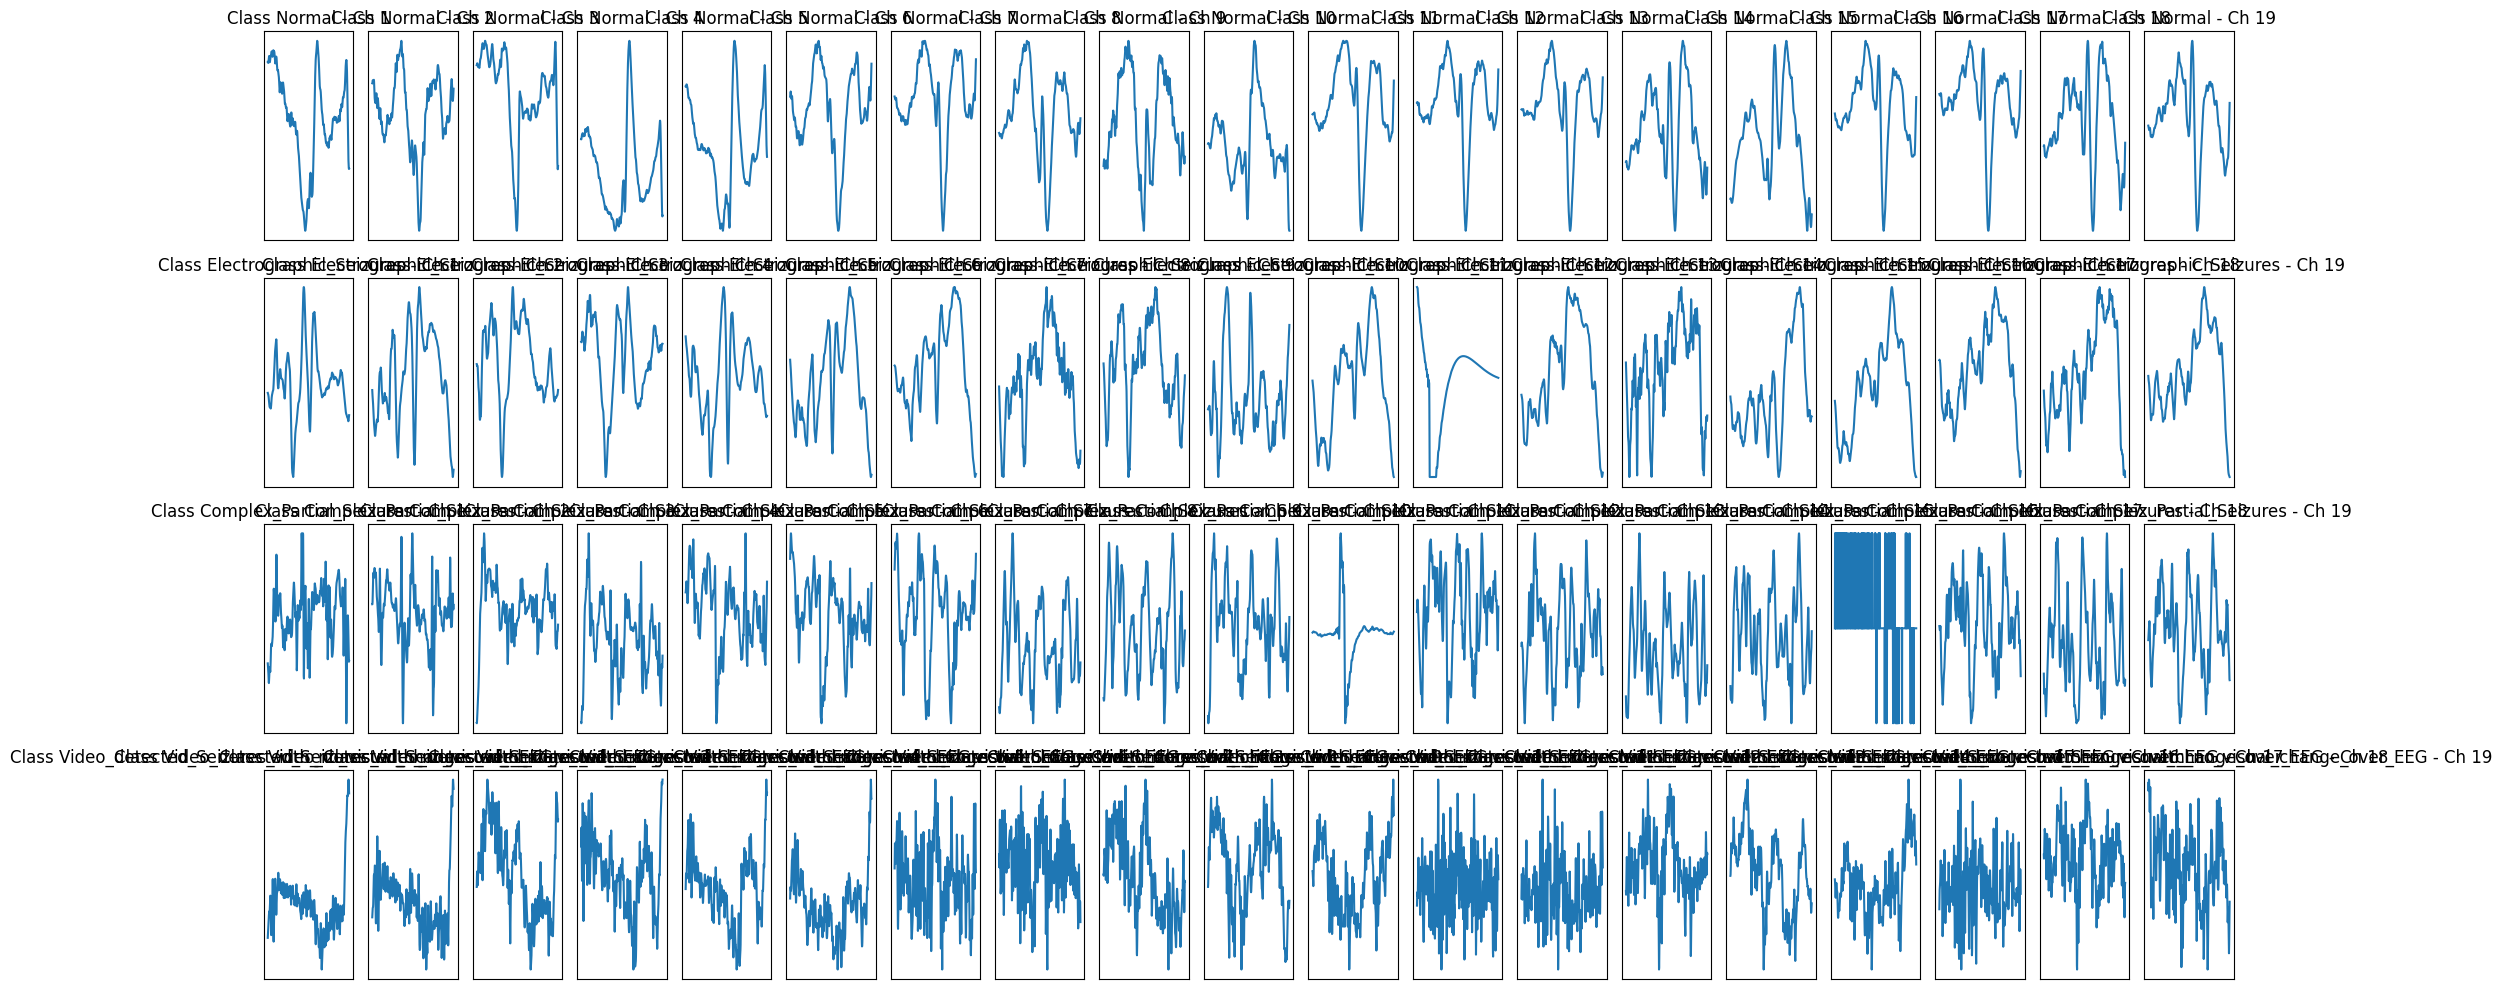

In [22]:
num_channels = sample_data["Normal"].shape[0]  

fig, axes = plt.subplots(len(classes), num_channels, figsize=(20, 10))

for i, (cls, signal) in enumerate(sample_data.items()):
    for ch in range(num_channels):
        axes[i, ch].plot(signal[ch])
        axes[i, ch].set_title(f"Class {cls} - Ch {ch+1}")
        axes[i, ch].set_xticks([])
        axes[i, ch].set_yticks([])

plt.tight_layout()
plt.show()


<ipython-input-23-4988d768be77>:10: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


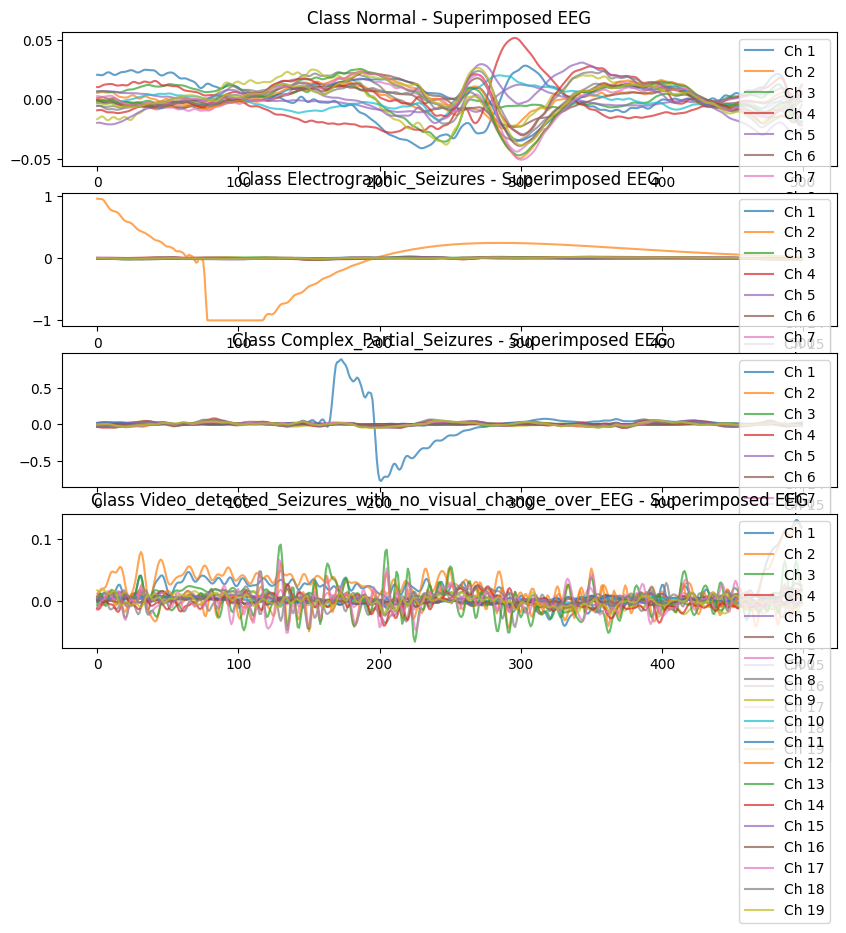

In [23]:
fig, axes = plt.subplots(len(classes), 1, figsize=(10, 8))

for i, (cls, signal) in enumerate(sample_data.items()):
    for ch in range(num_channels):
        axes[i].plot(signal[ch], alpha=0.7, label=f"Ch {ch+1}")

    axes[i].set_title(f"Class {cls} - Superimposed EEG")
    axes[i].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [24]:
from scipy.signal import find_peaks

def zero_crossing_rate(signal):
    """ Compute the number of times a signal crosses zero. """
    return ((np.diff(np.sign(signal)) != 0).sum()) / len(signal)

def compute_statistics(signal):
    """ Compute time-domain statistics for an EEG signal. """
    mean_val = np.mean(signal)
    zero_crossings = zero_crossing_rate(signal)
    value_range = np.max(signal) - np.min(signal)
    energy = np.sum(np.square(signal))
    rms = np.sqrt(np.mean(np.square(signal)))
    variance = np.var(signal)

    return [mean_val, zero_crossings, value_range, energy, rms, variance]

stats_df = pd.DataFrame(columns=["Class", "Channel", "Mean", "Zero Crossing Rate", "Range", "Energy", "RMS", "Variance"])

for cls, signal in sample_data.items():
    for ch in range(num_channels):
        stats = compute_statistics(signal[ch])
        stats_df.loc[len(stats_df)] = [cls, ch+1] + stats

print(stats_df.head())

# Save to CSV
stats_df.to_csv("EEG_Time_Domain_Statistics.csv", index=False)


    Class  Channel      Mean  Zero Crossing Rate     Range    Energy  \
0  Normal        1 -0.000347               0.038  0.069153  0.145882   
1  Normal        2 -0.000478               0.016  0.038361  0.030282   
2  Normal        3 -0.000337               0.010  0.048157  0.056461   
3  Normal        4 -0.002792               0.010  0.079285  0.159185   
4  Normal        5 -0.000800               0.010  0.023132  0.014930   

        RMS  Variance  
0  0.017081  0.000292  
1  0.007782  0.000060  
2  0.010626  0.000113  
3  0.017843  0.000311  
4  0.005464  0.000029  


<ipython-input-26-45034e1375b1>:28: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


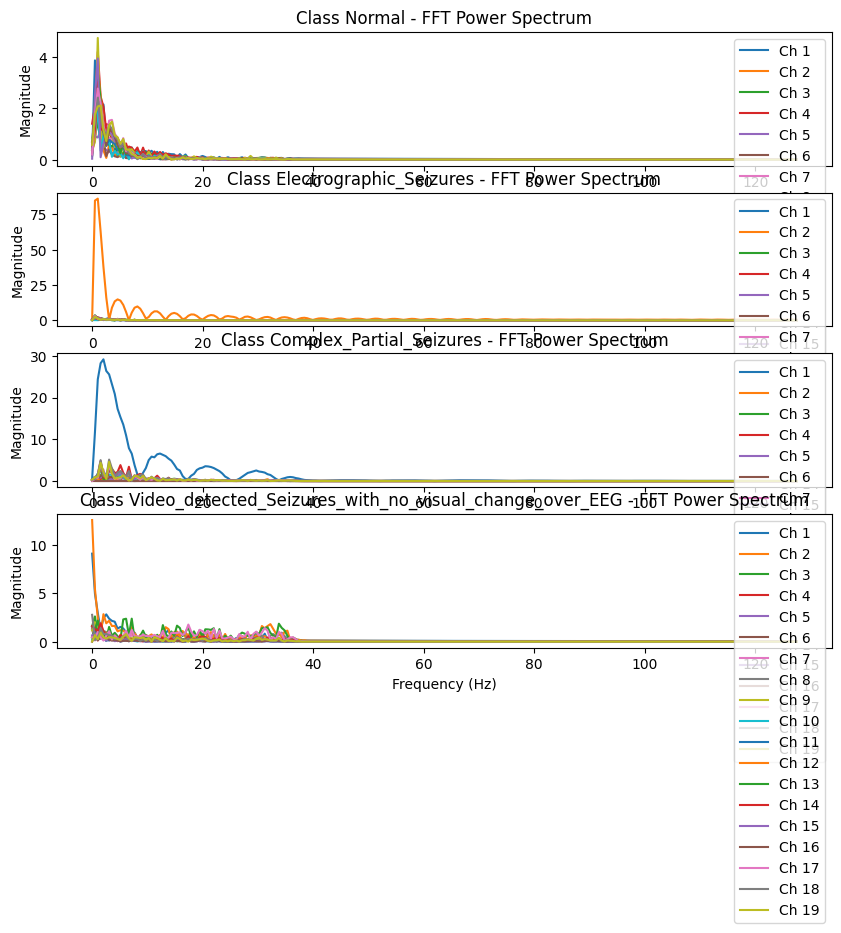

In [26]:
from scipy.fftpack import fft, fftfreq

# sampling rate 
sampling_rate = 256  
num_channels = sample_data["Normal"].shape[0]


fft_data = {}

# Apply FFT to each sample
for cls, signal in sample_data.items():
    fft_result = np.abs(fft(signal))  
    freqs = fftfreq(signal.shape[1], d=1/sampling_rate)  
    fft_data[cls] = (freqs, fft_result)

# Power Spectrum
fig, axes = plt.subplots(len(classes), 1, figsize=(10, 8))

for i, (cls, (freqs, fft_result)) in enumerate(fft_data.items()):
    for ch in range(num_channels):
        axes[i].plot(freqs[:len(freqs)//2], fft_result[ch][:len(freqs)//2], label=f"Ch {ch+1}")

    axes[i].set_title(f"Class {cls} - FFT Power Spectrum")
    axes[i].set_xlabel("Frequency (Hz)")
    axes[i].set_ylabel("Magnitude")
    axes[i].legend(loc="upper right")

plt.tight_layout()
plt.show()


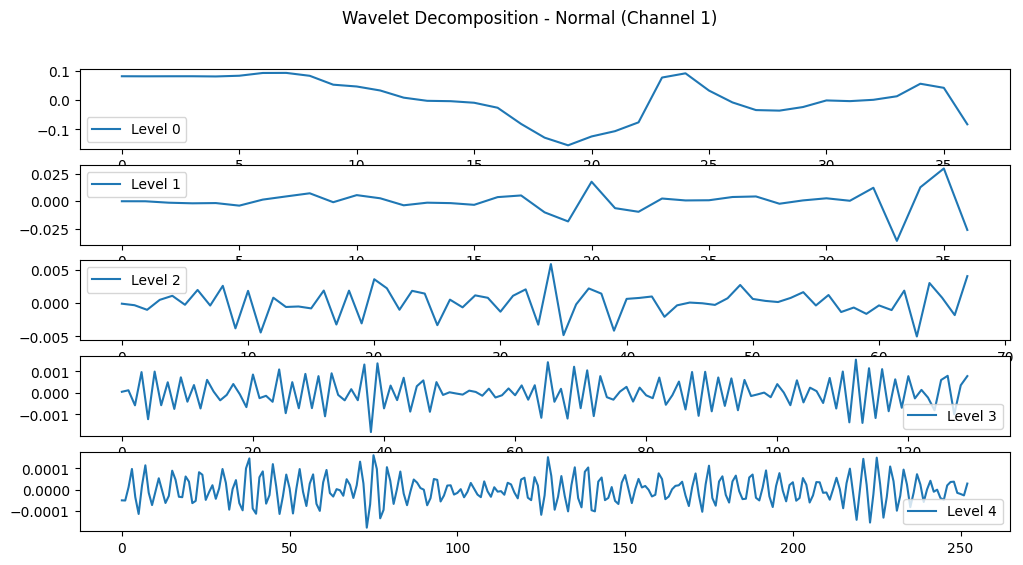

In [28]:
import pywt

# wavelet coefficients
wavelet_data = {}

# Define wavelet type
wavelet = 'db4'  

for cls, signal in sample_data.items():
    coeffs = [pywt.wavedec(signal[ch], wavelet, level=4) for ch in range(num_channels)]
    wavelet_data[cls] = coeffs


cls_example = "Normal"  
ch_example = 0  

coeffs_example = wavelet_data[cls_example][ch_example]

plt.figure(figsize=(12, 6))
for i, coeff in enumerate(coeffs_example):
    plt.subplot(len(coeffs_example), 1, i+1)
    plt.plot(coeff, label=f"Level {i}")
    plt.legend()

plt.suptitle(f"Wavelet Decomposition - {cls_example} (Channel {ch_example+1})")
plt.show()


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score

# extract features from EEG data
def extract_features(signal):
    """
    Extracts Fourier Transform (FFT) features & Zero Crossing Rate (ZCR) for each EEG channel.
    Returns a feature vector for one EEG sample.
    """
    num_channels, num_samples = signal.shape

    # FFT and take sum of magnitudes as features
    fft_features = np.sum(np.abs(fft(signal)), axis=1)

    #  Zero Crossing Rate for each channel
    zcr_features = np.array([zero_crossing_rate(signal[ch]) for ch in range(num_channels)])

    # FFT and ZCR features
    feature_vector = np.concatenate([fft_features, zcr_features])

    return feature_vector


X = []
y = []


for cls_idx, cls in enumerate(classes):  
    class_folder = os.path.join(data_root, cls)
    
    for file_name in os.listdir(class_folder):
        if file_name.endswith(".npy"):
            file_path = os.path.join(class_folder, file_name)
            eeg_signal = np.load(file_path)


            X.append(extract_features(eeg_signal))
            y.append(cls_idx)  


X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [30]:
# Train SVM classifier
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on validation set
y_pred = svm_model.predict(X_val)
y_probs = svm_model.predict_proba(X_val)

# Evaluate performance
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_probs, multi_class="ovr"))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       557
           1       0.96      0.95      0.96       106
           2       0.95      0.92      0.94       439
           3       1.00      0.76      0.87        17

    accuracy                           0.95      1119
   macro avg       0.96      0.90      0.93      1119
weighted avg       0.95      0.95      0.95      1119

Balanced Accuracy Score: 0.9017015502601017
ROC AUC Score: 0.992980334472483


In [31]:
import scipy.signal as signal
import cv2

def compute_spectrogram(eeg_signal, sampling_rate=256):
    """
    Convert EEG signal into a Spectrogram (image-like format).
    """
    num_channels, num_samples = eeg_signal.shape
    spectrograms = []

    for ch in range(num_channels):
        f, t, Sxx = signal.spectrogram(eeg_signal[ch], fs=sampling_rate)
        
        # Normalize and Resize
        Sxx = cv2.resize(Sxx, (64, 64))  
        Sxx = (Sxx - np.min(Sxx)) / (np.max(Sxx) - np.min(Sxx))  # Normalize

        spectrograms.append(Sxx)

    return np.array(spectrograms)


X_spectrogram = np.array([compute_spectrogram(np.load(os.path.join(data_root, cls, f)))
                          for cls in classes for f in os.listdir(os.path.join(data_root, cls)) if f.endswith(".npy")])

y_labels = np.array([i for i, cls in enumerate(classes) for f in os.listdir(os.path.join(data_root, cls)) if f.endswith(".npy")])

X_spectrogram = X_spectrogram.reshape(len(X_spectrogram), 64, 64, num_channels)

# Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X_spectrogram, y_labels, test_size=0.2, random_state=42, stratify=y_labels)


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Build CNN Model
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, num_channels)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  
])

# Compile Model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train CNN Model
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.4595 - loss: 3.9062 - val_accuracy: 0.4987 - val_loss: 1.1692
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5262 - loss: 1.0235 - val_accuracy: 0.6023 - val_loss: 1.0606
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5410 - loss: 0.9764 - val_accuracy: 0.5880 - val_loss: 0.9621
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5874 - loss: 0.8781 - val_accuracy: 0.7033 - val_loss: 0.8527
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5992 - loss: 0.8742 - val_accuracy: 0.6425 - val_loss: 0.7678
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6106 - loss: 0.8282 - val_accuracy: 0.6381 - val_loss: 0.8121
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5939 - loss: 0.8662 - val_accuracy: 0.7122 - val_loss: 0.7214
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6148 - loss: 0.8118 - val_acc

In [33]:
# Predict on Validation Set
y_pred = np.argmax(cnn_model.predict(X_val), axis=1)

print("Classification Report:\n", classification_report(y_val, y_pred))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, cnn_model.predict(X_val), multi_class="ovr"))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.99      0.75       557
           1       0.00      0.00      0.00       106
           2       0.91      0.42      0.58       439
           3       0.92      0.65      0.76        17

    accuracy                           0.67      1119
   macro avg       0.61      0.51      0.52      1119
weighted avg       0.67      0.67      0.61      1119

Balanced Accuracy Score: 0.5139759498144166


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
ROC AUC Score: 0.8832497921510183


In [34]:
import shap

# Explain the CNN Model using SHAP
explainer = shap.Explainer(cnn_model, X_val)
shap_values = explainer(X_val[:10])  

shap.summary_plot(shap_values, X_val[:10])


TypeError: 'numpy.ndarray' object is not callable